In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
#import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
#sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
df=pd.read_csv('PGCB_Demand_Data_2021.csv')
df["DateTime"] = pd.to_datetime(df.date.astype(str) + ' ' + df.hour.astype(str), format='%m/%d/%Y %H')
df["DateTime"]=pd.to_datetime(df["DateTime"])
df.set_index("DateTime",inplace=True)
df

,date,year,month,day,weekday,hour,demand
DateTime,,,,,,,
2018-01-01 00:00:00,1/1/2018,2018,1,1,2,0,5673.00
2018-01-01 01:00:00,1/1/2018,2018,1,1,2,1,5183.00
2018-01-01 02:00:00,1/1/2018,2018,1,1,2,2,4908.00
2018-01-01 03:00:00,1/1/2018,2018,1,1,2,3,4786.00
2018-01-01 04:00:00,1/1/2018,2018,1,1,2,4,4599.00
...,...,...,...,...,...,...,...
2021-03-15 19:00:00,3/15/2021,2021,3,15,2,19,10321.02
2021-03-15 20:00:00,3/15/2021,2021,3,15,2,20,11242.00
2021-03-15 21:00:00,3/15/2021,2021,3,15,2,21,10994.12


In [3]:
df.shape

(28080, 7)

In [4]:
#sns.lineplot(x=df.index, y="demand", data=df);

In [5]:
#sns.lineplot(x='month', y="demand", data=df);

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed=seasonal_decompose(df["demand"],
                             model='additive'
                             )

In [7]:
trend=decomposed.trend
sesonal=decomposed.seasonal
residual=decomposed.resid

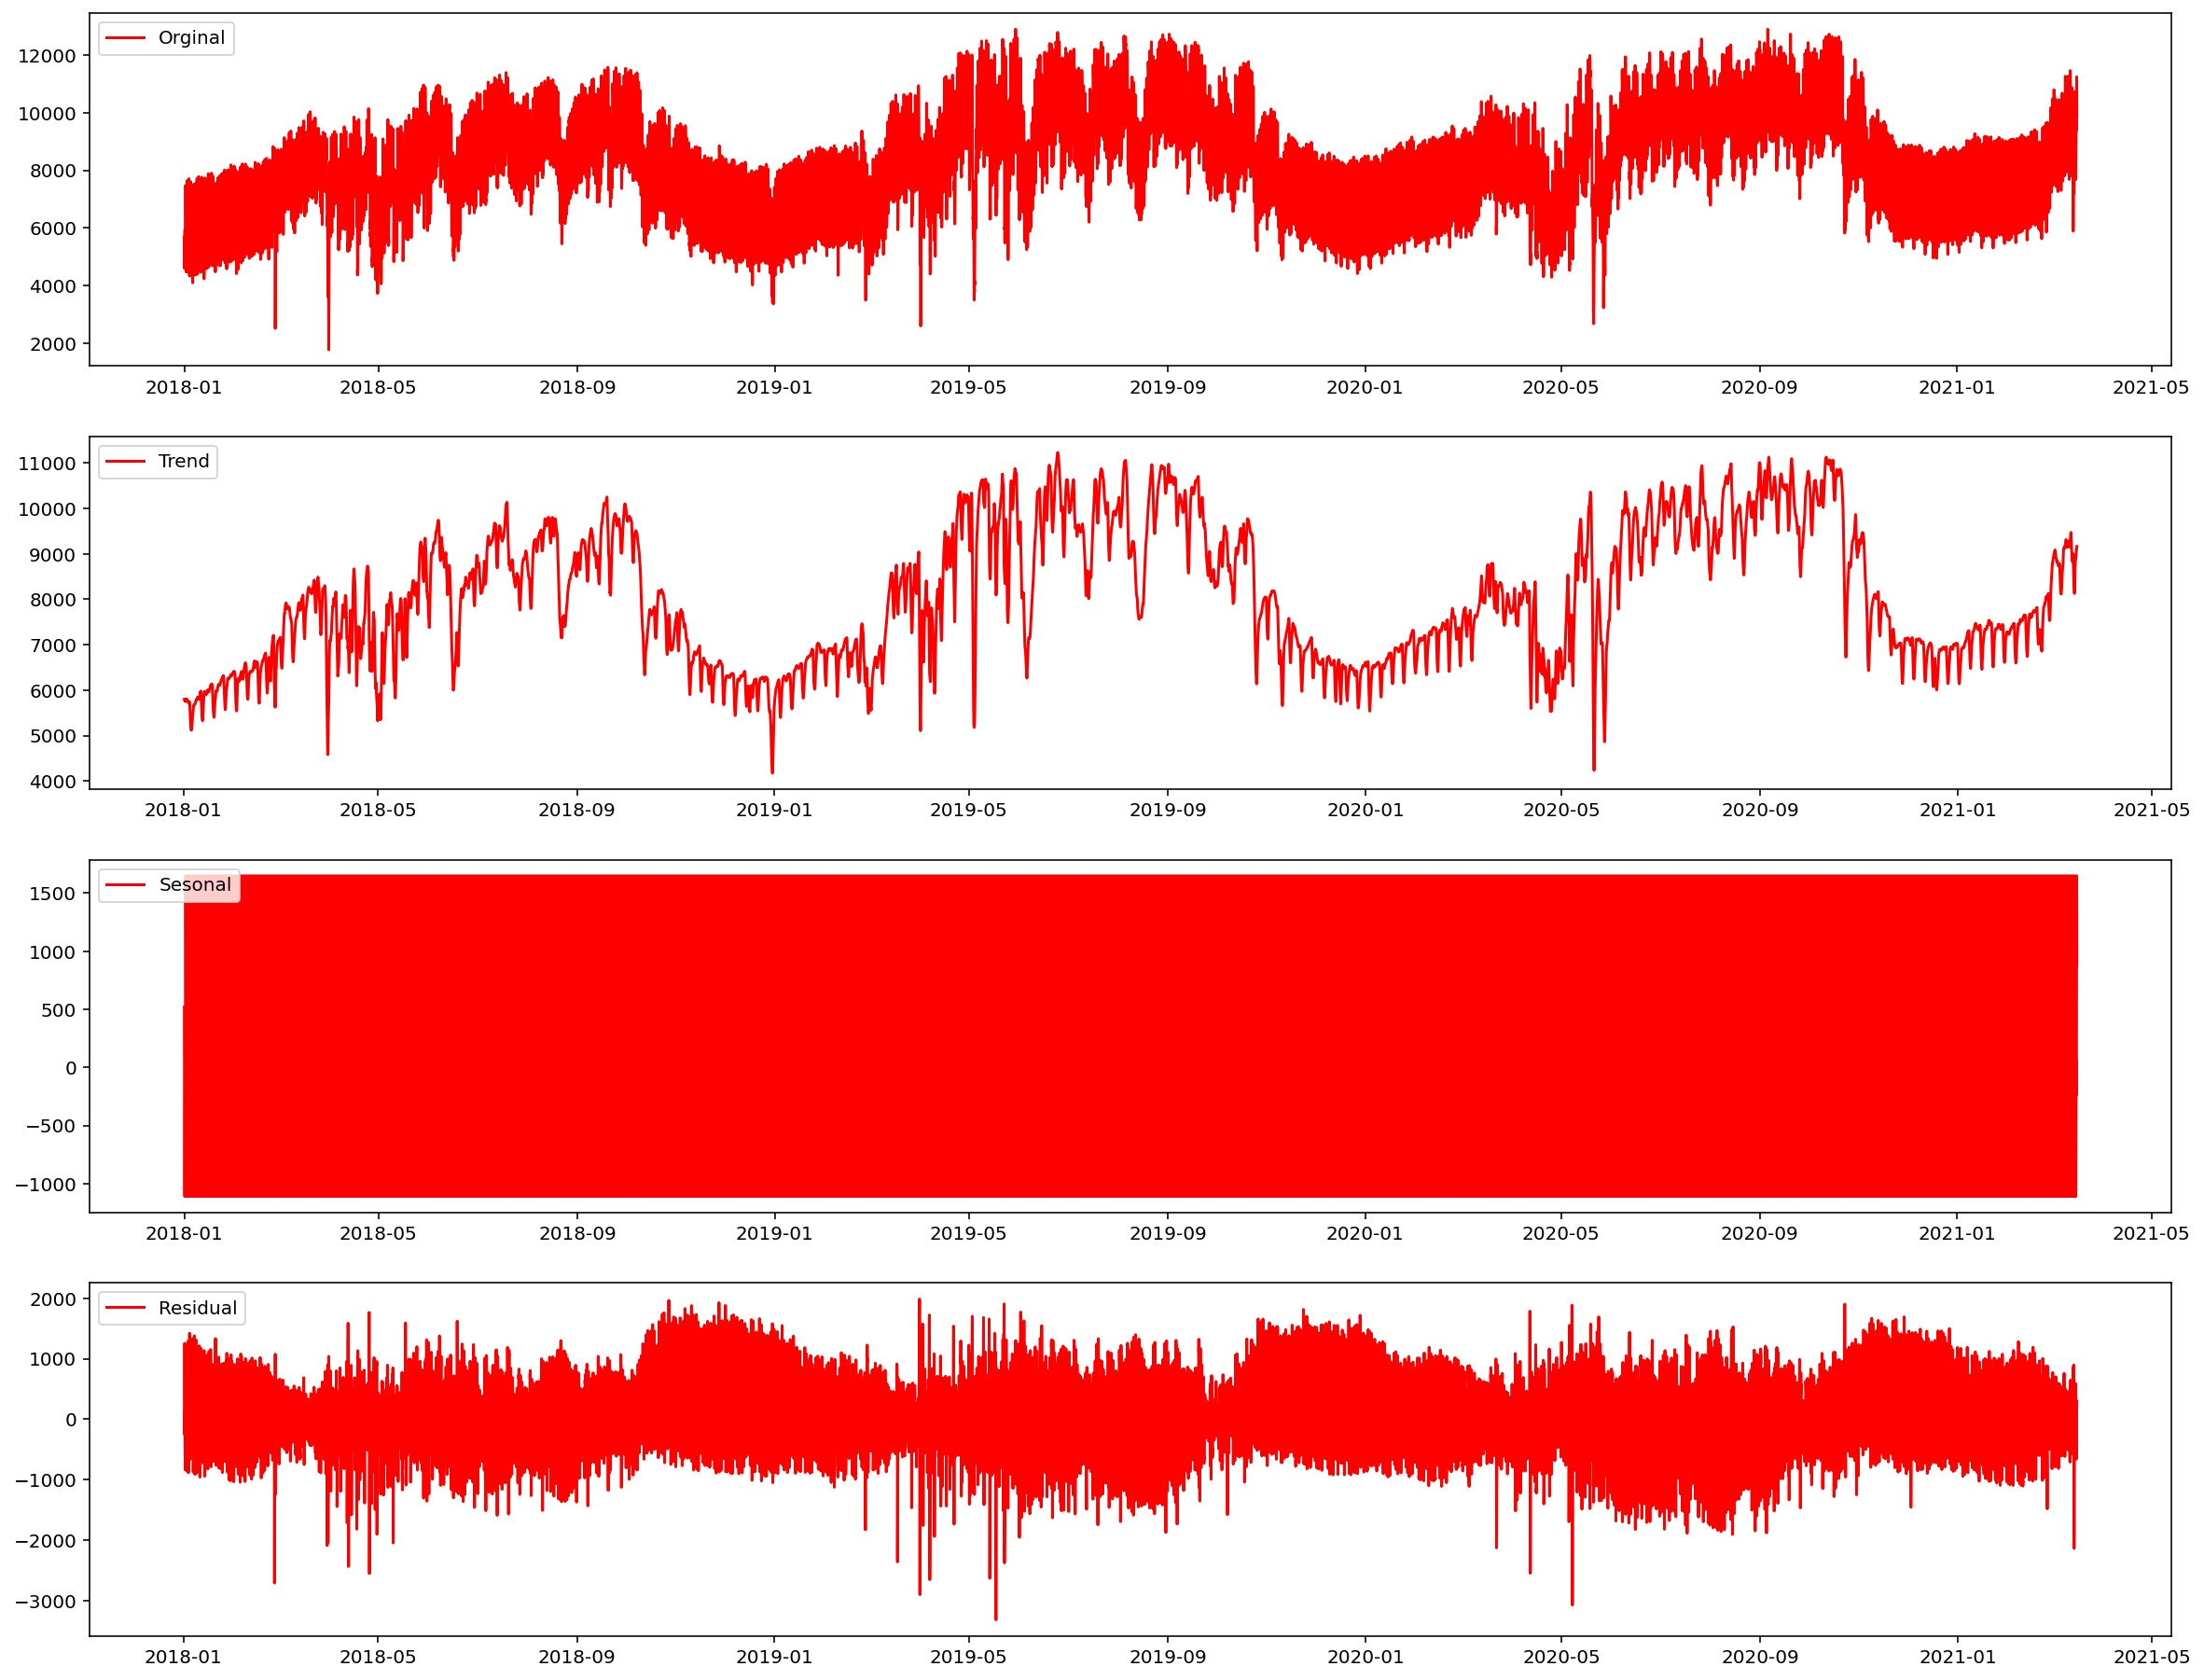

In [8]:
plt.figure(figsize=(20,16))
plt.subplot(411)
plt.plot(df["demand"],label="Orginal",color='red')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend,label="Trend",color='red')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(sesonal,label="Sesonal",color='red')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual,label="Residual",color='red')
plt.legend(loc='upper left')
plt.show()

In [9]:
# from sklearn.preprocessing import MinMaxScaler
# scaler=MinMaxScaler(feature_range=(0,1))
# X=scaler.fit_transform(df.demand.values.reshape(-1,1))
D_max_daily = df.groupby(df.index).demand.max().to_numpy()
df.demand= df.demand/max(D_max_daily)
D_max=max(D_max_daily)

In [10]:
##splitting dataset into train and test split
training_size=int(len(df)*0.65)
test_size=len(df)-training_size
train_data,test_data=df.demand[0:training_size],df.demand[training_size:len(df)]

In [11]:
train=train_data.values.reshape(-1,1)
test=test_data.values.reshape(-1,1)

In [12]:
train.shape

(18252, 1)

In [13]:
test.shape

(9828, 1)

In [14]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [15]:
# # convert an array of values into a dataset matrix
# def create_dataset(dataset, time_step=1):
#	dataX, dataY = [], []
# 	for i in range(time_step,len(dataset)-time_step):
# 		dataX.append(dataset[i-time_step:i])   ###i=0, 0,1,2,3-----99   100 
# 		dataY.append(dataset[i:i+time_step])
# 	return np.array(dataX), np.array(dataY)



In [16]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 24*7 # take time laps for 7 days
X_train, y_train = create_dataset(train, time_step)
X_test, ytest = create_dataset(test, time_step)

In [17]:
print(X_train.shape)
print(y_train.shape)



(18083, 168)
(18083,)


In [18]:
print(X_test.shape)
print(ytest.shape)

(9659, 168)
(9659,)


In [19]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [20]:
#print(X_train[:3])
#print(y_train[:3])
#print(X_test.shape)
#print(len(X_train[1]))
print(X_train[0])

[[0.4400062 ]
 [0.40200109]
 [0.38067168]
 [0.37120918]
 [0.35670519]
 [0.35631738]
 [0.37710385]
 [0.40262158]
 [0.43395641]
 [0.45970682]
 [0.44365159]
 [0.446056  ]
 [0.45024432]
 [0.45520825]
 [0.43201737]
 [0.4321725 ]
 [0.43038858]
 [0.45869852]
 [0.5668192 ]
 [0.57360583]
 [0.58039246]
 [0.55890793]
 [0.51260374]
 [0.47863182]
 [0.43054371]
 [0.3909098 ]
 [0.36291011]
 [0.3564725 ]
 [0.34840611]
 [0.34685488]
 [0.3655472 ]
 [0.39641666]
 [0.43845498]
 [0.45032188]
 [0.44528038]
 [0.44093694]
 [0.45326922]
 [0.45986194]
 [0.44194524]
 [0.44559063]
 [0.44070426]
 [0.47351276]
 [0.5654231 ]
 [0.57919026]
 [0.59295742]
 [0.56480261]
 [0.5221438 ]
 [0.45924145]
 [0.42309781]
 [0.39789033]
 [0.37144187]
 [0.36686574]
 [0.34770806]
 [0.3520515 ]
 [0.36764136]
 [0.39292639]
 [0.4291476 ]
 [0.45978438]
 [0.44915846]
 [0.43232762]
 [0.44326379]
 [0.45164043]
 [0.42674319]
 [0.4400062 ]
 [0.44210036]
 [0.46342977]
 [0.56759482]
 [0.58268052]
 [0.59776623]
 [0.57915148]
 [0.51880866]
 [0.45

In [21]:
X_train

array([[[0.4400062 ],
        [0.40200109],
        [0.38067168],
        ...,
        [0.55247033],
        [0.50888079],
        [0.45559606]],

       [[0.40200109],
        [0.38067168],
        [0.37120918],
        ...,
        [0.50888079],
        [0.45559606],
        [0.41503141]],

       [[0.38067168],
        [0.37120918],
        [0.35670519],
        ...,
        [0.45559606],
        [0.41503141],
        [0.37702629]],

       ...,

       [[0.45280385],
        [0.46622198],
        [0.45365702],
        ...,
        [0.43915303],
        [0.45094237],
        [0.47925231]],

       [[0.46622198],
        [0.45365702],
        [0.44791747],
        ...,
        [0.45094237],
        [0.47925231],
        [0.50042659]],

       [[0.45365702],
        [0.44791747],
        [0.46342977],
        ...,
        [0.47925231],
        [0.50042659],
        [0.51826573]]])

In [26]:
from keras.models import Sequential
from keras.layers import Conv1D, Dropout, Dense, Flatten, LSTM, MaxPooling1D, Bidirectional,GRU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import Input, LSTM, Dense, LSTMCell, RNN, Bidirectional, concatenate

from keras.layers import TimeDistributed

from keras.layers import RepeatVector
from keras.layers import TimeDistributed

from keras.models import Model


In [27]:
# # model=Sequential()
# # model.add(LSTM(50,input_shape=(X_train.shape[1],X_train.shape[2])))
# # model.add(RepeatVector(168))

# # model.add(LSTM(50,return_sequences=True))

# # model.add(TimeDistributed(Dense(100, activation='relu')))
# # model.add(LSTM(50))

# # model.add(Dense(1))

# # model.compile(loss='mean_absolute_percentage_error',optimizer='adam')




# input_seq_len = 60
# output_seq_len = 20
# n_in_features = 1
# n_out_features = 1
# batch_size = 10



# # encoder_inputs = Input(shape=(None, n_in_features))
# # lstm_cells = [LSTMCell(hidden_dim) for hidden_dim in layers]

# # encoder = RNN(lstm_cells, return_state=True)
# # encoder_outputs_and_states = encoder(encoder_inputs)
# # encoder_states = encoder_outputs_and_states[1:]

# # decoder_cells = [LSTMCell(hidden_dim) for hidden_dim in layers]
# # decoder_lstm = RNN(decoder_cells, return_sequences=True, return_state=True)

# # decoder_outputs_and_states = decoder_lstm(decoder_inputs,
# #                                       initial_state=encoder_states)
# # decoder_outputs = decoder_outputs_and_states[0]

# # decoder_dense = Dense(n_out_features) 
# # decoder_outputs = decoder_dense(decoder_outputs)

# # model = Model([encoder_inputs,decoder_inputs], decoder_outputs)



# def create_model(layers, bidirectional=False):
    
#     n_layers = len(layers)
    
#     ## Encoder
#     encoder_inputs = Input(shape=(None, n_in_features))
#     lstm_cells = [LSTMCell(hidden_dim) for hidden_dim in layers]
#     if bidirectional:
#         encoder = Bidirectional(RNN(lstm_cells, return_state=True))
#         encoder_outputs_and_states = encoder(encoder_inputs)
#         bi_encoder_states = encoder_outputs_and_states[1:]
#         encoder_states = []
#         for i in range(int(len(bi_encoder_states)/2)):
#             temp = concatenate([bi_encoder_states[i],bi_encoder_states[2*n_layers + i]], axis=-1)
#             encoder_states.append(temp)
#     else:  
#         encoder = RNN(lstm_cells, return_state=True)
#         encoder_outputs_and_states = encoder(encoder_inputs)
#         encoder_states = encoder_outputs_and_states[1:]
    
#     ## Decoder
#     decoder_inputs = Input(shape=(None, n_out_features))
#     if bidirectional:
#         decoder_cells = [LSTMCell(hidden_dim*2) for hidden_dim in layers]
#     else:
#         decoder_cells = [LSTMCell(hidden_dim) for hidden_dim in layers]
        
#     decoder_lstm = RNN(decoder_cells, return_sequences=True, return_state=True)

#     decoder_outputs_and_states = decoder_lstm(decoder_inputs,
#                                           initial_state=encoder_states)
#     decoder_outputs = decoder_outputs_and_states[0]

#     decoder_dense = Dense(n_out_features) 
#     decoder_outputs = decoder_dense(decoder_outputs)
    
#     model = Model([encoder_inputs,decoder_inputs], decoder_outputs)
#     return model




model = Sequential()


model.add(LSTM(128, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=False))
model.add(RepeatVector(1))
model.add(LSTM(32, activation='relu',return_sequences=True))
#model.add(Dropout(0.1))  
model.add(TimeDistributed(Dense(1))) 
model.compile(loss='mean_absolute_percentage_error',optimizer='adam')


In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               66560     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 128)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 32)             20608     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 1)              33        
Total params: 87,201
Trainable params: 87,201
Non-trainable params: 0
_________________________________________________________________


In [31]:
import time
start_time = time.time()
history=model.fit(X_train,y_train,epochs = 30, batch_size=64,validation_split=0.1)
finish_time = time.time()
print("--- %s seconds ---" % (finish_time - start_time))



Epoch 1/30
255/255 [==============================] - 85s 332ms/step - loss: 4.6570 - val_loss: 4.8066
Epoch 2/30
255/255 [==============================] - 98s 385ms/step - loss: 4.6130 - val_loss: 4.8471
Epoch 3/30
255/255 [==============================] - 68s 267ms/step - loss: 4.6072 - val_loss: 4.7178
Epoch 4/30
255/255 [==============================] - 64s 252ms/step - loss: 4.5812 - val_loss: 4.7357
Epoch 5/30
255/255 [==============================] - 69s 269ms/step - loss: 4.5624 - val_loss: 4.6834
Epoch 6/30
255/255 [==============================] - 54s 210ms/step - loss: 4.5317 - val_loss: 4.6197
Epoch 7/30
255/255 [==============================] - 49s 193ms/step - loss: 4.5029 - val_loss: 4.6820
Epoch 8/30
255/255 [==============================] - 54s 210ms/step - loss: 4.5217 - val_loss: 4.6313
Epoch 9/30
255/255 [==============================] - 60s 234ms/step - loss: 4.4715 - val_loss: 4.5375
Epoch 10/30
255/255 [==============================] - 80s 314ms/step - l

In [ ]:
# print((finish_time - start_time)/60,'minutes')
scores = model.evaluate(X_test, ytest)
print("TEST MAPE :",scores)

203/302 [===================>..........] - ETA: 8s - loss: 3.7326

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], linewidth =4)
plt.plot(history.history['val_loss'], linewidth =4)
#plt.grid(False)
a =  plt.legend(['train loss','validation loss'])



plt.show()

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
new_train_predict=train_predict.reshape((train_predict.shape[0]))
new_test_predict=test_predict.reshape((test_predict.shape[0]))


In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train*D_max,new_train_predict*D_max))

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest*D_max,new_test_predict*D_max))

In [ ]:
new_train_predict.shape

In [ ]:
y_train_rs=y_train.reshape(-1,1)
y_train_rs.shape

In [ ]:
df.demand.shape

In [ ]:
train_predict.shape

In [ ]:
test_predict.shape

In [ ]:
plt.plot(new_test_predict*D_max)
plt.plot(ytest*D_max)
plt.legend(['PREDICTED','ACTUAL'])

In [ ]:
plt.plot(new_test_predict[:24]*D_max, linewidth = 4)
plt.plot(ytest[:24]*D_max, linewidth = 4)
plt.grid(False)
plt.legend(['PREDICTED','ACTUAL'])


In [ ]:
nsamples, nx, ny = X_train.shape
d2_train_dataset = X_train.reshape((nsamples,nx*ny))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
cls = RandomForestRegressor(n_estimators=1,min_samples_leaf=100)
cls.fit(d2_train_dataset,y_train)

In [ ]:
nsamples, nx, ny = X_test.shape
d2_test_dataset = X_test.reshape((nsamples,nx*ny))

In [ ]:
sk_pred=cls.predict(d2_test_dataset)

In [ ]:
plt.plot(sk_pred[0:24]*D_max, linewidth = 4)
plt.plot(ytest[0:24]*D_max, linewidth = 4)
plt.grid(False)

plt.legend(['PREDICTED(RF)','ACTUAL'])

In [ ]:
import sklearn.metrics
from sklearn.metrics import mean_squared_error

In [ ]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [ ]:
MAPE_RF=mean_absolute_percentage_error(ytest,sk_pred)
MAPE_RF

In [ ]:
cls.score(d2_test_dataset,ytest)

In [ ]:
cls.feature_importances_

In [ ]:
importance = cls.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

In [ ]:
from matplotlib import pyplot
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [ ]:
cls.feature_importances_

In [ ]:
# Main function for calculating Mean Absolute Percentage Error
import sklearn.metrics
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [ ]:
MAPE_RF=mean_absolute_percentage_error(ytest,sk_pred)
MAPE_RF

In [ ]:
cls.score(d2_test_dataset,ytest)

In [ ]:
# #Function for calculating LSTM model MAPE value
# def LSTM_MAEP_RMSE(month,year):
#   year_dict = {2018: 1, 2019: 2, 2020: 3}

#   month_seq = {
#       "jan": 1,
#       "feb": 2,
#       "mar": 3,
#       "apr": 4,
#       "may": 5,
#       "jun": 6,
#       "jul": 7,
#       "aug": 8,
#       "sep": 9,
#       "oct": 10,
#       "nov": 11,
#       "dec": 12,
#   }

#   month_dict = {
#       "jan": (0, 31),
#       "feb": (31, 59),
#       "mar": (59, 90),
#       "apr": (90, 120),
#       "may": (120, 151),
#       "jun": (151, 181),
#       "jul": (181, 212),
#       "aug": (212, 243),
#       "sep": (243, 273),
#       "oct": (273, 304),
#       "nov": (304, 334),
#       "dec": (334, 365)
#   } 

#   st = year_dict[year]*365+(month_dict[month][0] + (1 if year == 2020 and month_seq[month] > 2 else 0))*24
#   en = year_dict[year]*365+(month_dict[month][1] + (1 if year == 2020 and month_seq[month] >= 2 else 0))*24
#   test_y_jan = []
#   true_y_jan = []
#   for i in range(st, en):
#       test = X_train[i]
#       true_y_jan.append(ytest[i])
#       test = test.reshape(1,1,5)
#       y = model.predict(test)
#       test_y_jan.append(y[0][0])
#   return mean_absolute_percentage_error(true_y_jan,test_y_jan)

In [ ]:
# #Function for calculating RF model MAPE value
# def RF_MAPE_RMSE(month,year):
#   year_dict = {2018: 1, 2019: 2, 2020: 3}

#   month_seq = {
#       "jan": 1,
#       "feb": 2,
#       "mar": 3,
#       "apr": 4,
#       "may": 5,
#       "jun": 6,
#       "jul": 7,
#       "aug": 8,
#       "sep": 9,
#       "oct": 10,
#       "nov": 11,
#       "dec": 12,
#   }

#   month_dict = {
#       "jan": (0, 31),
#       "feb": (31, 59),
#       "mar": (59, 90),
#       "apr": (90, 120),
#       "may": (120, 151),
#       "jun": (151, 181),
#       "jul": (181, 212),
#       "aug": (212, 243),
#       "sep": (243, 273),
#       "oct": (273, 304),
#       "nov": (304, 334),
#       "dec": (334, 365)
#   } 

#   st = year_dict[year]*365+(month_dict[month][0] + (1 if year == 2020 and month_seq[month] > 2 else 0))*24
#   en = year_dict[year]*365+(month_dict[month][1] + (1 if year == 2020 and month_seq[month] >= 2 else 0))*24
#   test_y_jan = []
#   true_y_jan = []
#   for i in range(st, en):
#     test = X_train[i]
#     true_y_jan.append(Y[i])
#     test = test.reshape(1,1*5)
#     y = cls.predict(test)
#     test_y_jan.append(y[0])
#   return mean_absolute_percentage_error(true_y_jan,test_y_jan)

In [ ]:
# JANUARY_LSTM_MAPE=LSTM_MAEP_RMSE("jan",2020)
# MARCH_LSTM_MAPE=LSTM_MAEP_RMSE("mar",2020)
# JUNE_LSTM_MAPE=LSTM_MAEP_RMSE("jun",2020)
# SEPTEMBER_LSTM_MAPE=LSTM_MAEP_RMSE("sep",2020)
# DECEMBER_LSTM_MAPE=LSTM_MAEP_RMSE("dec",2020)

In [ ]:
train.shape

In [ ]:
gData=df.demand.values.reshape(-1,1)

In [ ]:
gData[:10]

In [ ]:
gX, gY = create_dataset(gData, time_step)

In [ ]:
gX.shape

In [ ]:
gY.shape

In [ ]:
gX =gX.reshape(gX.shape[0],gX.shape[1] , 1)
gX.shape
pred_gX=model.predict(gX)

In [ ]:
#Function for calculating LSTM model MAPE value
def LSTM_MAEP_RMSE(month,year):
  year_dict = {2018: 1, 2019: 2, 2020: 3}

  month_seq = {
      "jan": 1,
      "feb": 2,
      "mar": 3,
      "apr": 4,
      "may": 5,
      "jun": 6,
      "jul": 7,
      "aug": 8,
      "sep": 9,
      "oct": 10,
      "nov": 11,
      "dec": 12,
  }

  month_dict = {
      "jan": (0, 31),
      "feb": (31, 59),
      "mar": (59, 90),
      "apr": (90, 120),
      "may": (120, 151),
      "jun": (151, 181),
      "jul": (181, 212),
      "aug": (212, 243),
      "sep": (243, 273),
      "oct": (273, 304),
      "nov": (304, 334),
      "dec": (334, 365)
  } 

  st = year_dict[year]*365+(month_dict[month][0] + (1 if year == 2020 and month_seq[month] > 2 else 0))*24
  en = year_dict[year]*365+(month_dict[month][1] + (1 if year == 2020 and month_seq[month] >= 2 else 0))*24
  test_y_jan = []
  true_y_jan = []
  for i in range(st, en):
    test_y_jan.append(pred_gX[i])
    true_y_jan.append(gY[i])
      
  return mean_absolute_percentage_error(true_y_jan,test_y_jan)

In [ ]:
pred_gX.shape
pred_gX=pred_gX.reshape(pred_gX.shape[0])

In [ ]:
gY.shape

In [ ]:
JANUARY_LSTM_MAPE=LSTM_MAEP_RMSE("jan",2020)
MARCH_LSTM_MAPE=LSTM_MAEP_RMSE("mar",2020)
JUNE_LSTM_MAPE=LSTM_MAEP_RMSE("jun",2020)
SEPTEMBER_LSTM_MAPE=LSTM_MAEP_RMSE("sep",2020)
DECEMBER_LSTM_MAPE=LSTM_MAEP_RMSE("dec",2020)

In [ ]:
print(JANUARY_LSTM_MAPE)
print(JUNE_LSTM_MAPE)
print(DECEMBER_LSTM_MAPE)
print(SEPTEMBER_LSTM_MAPE)
print(DECEMBER_LSTM_MAPE)

In [ ]:

def LSTM_MONTH_PLOT(month,year):

  year_dict = {2018: 1, 2019: 2, 2020: 3}

  month_seq = {
      "jan": 1,
      "feb": 2,
      "mar": 3,
      "apr": 4,
      "may": 5,
      "jun": 6,
      "jul": 7,
      "aug": 8,
      "sep": 9,
      "oct": 10,
      "nov": 11,
      "dec": 12,
  }

  month_dict = {
      "jan": (0, 31),
      "feb": (31, 59),
      "mar": (59, 90),
      "apr": (90, 120),
      "may": (120, 151),
      "jun": (151, 181),
      "jul": (181, 212),
      "aug": (212, 243),
      "sep": (243, 273),
      "oct": (273, 304),
      "nov": (304, 334),
      "dec": (334, 365)
  } 

  st = year_dict[year]*365+(month_dict[month][0] + (1 if year == 2020 and month_seq[month] > 2 else 0))*24
  en = year_dict[year]*365+(month_dict[month][1] + (1 if year == 2020 and month_seq[month] >= 2 else 0))*24
  test_y = []
  true_y = []
  for i in range(st, en,24):
    test_y.append(pred_gX[i]*D_max)
    true_y.append(gY[i]*D_max)
  
  plt.plot(test_y,linewidth = 4)
  plt.plot(true_y,linewidth = 4) 
  #plt.suptitle(f"{month.upper()} Month prediction comparison")
  plt.legend(["PREDICTED", "ACTUAL"])

In [ ]:
LSTM_MONTH_PLOT('jan',2020)



In [ ]:
LSTM_MONTH_PLOT('mar',2020)

In [ ]:
LSTM_MONTH_PLOT('jun',2020)


In [ ]:
LSTM_MONTH_PLOT('sep',2020)


In [ ]:
LSTM_MONTH_PLOT('dec',2020)
